In [1]:
import torch
import numpy as np


train_on_gpu = torch.cuda.is_available()
print("GPU present!!!") if train_on_gpu  else print("carry on with CPU:/ No GPU")

GPU present!!!


# Loading and Augmenting the Data


In [32]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

val_split =0.25
batch_size = 20

# Note: transform converts the raw image into proper pytorch tensor and applies various transformations
# as per the definition of the transform.
# transforms.ToTensor() converts the image to a 3 dimensional tensor
# and assuming that the range of image data is 0-255 it converts it in 0-1 range by dividing every value by 255
# transforms.normalize((0.5,0.5,0.5),(0.5,0.5,0.5)). Here the first tuple provides the mean value for (r,g,b)
# the second tuple provides the std. for each of (r,g,b) channel. The normalization transform assumes the range of the 
# data to be in 0-1. Spcially 0.5 value make data center around 0 in the range [-1,1]. 
# normalization = (val-mean)/std.
# Separate transformations can be designed for train and test data 

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# If we are using a standard popular dataset then they can be directly downloaded from the torchvision.datasets function
# for jupyter notebook it stores it in a directory on your local machine but in google colab it stores it on local google cloud

# loading training and testing datasets
traindata = torchvision.datasets.CIFAR10('data',train = True,download = True, transform = transform)
testdata = torchvision.datasets.CIFAR10('data',train = False, download = True, transform = transform)
#separate transform can be applied to train and test data if default dataset is used. When data is from image folder and splitted later then you can't separate the transform for test and train

# After loading the data separate training into the training and the validation set
num_training = len(traindata)
indices = list(range(num_training))
np.random.shuffle(indices) # this function returns none....it just randomly shuffles the input list
split = int(np.floor(num_training*val_split))
train_idx,val_idx = indices[:split],indices[split:]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx) #Samples elements randomly from a given list of indices, without replacement.
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

# Preparing data loaders for training, validation and test sets
train_loader = torch.utils.data.DataLoader(traindata,batch_size=batch_size,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(traindata,batch_size=batch_size,sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [33]:
#helper function to convert images back to numpy array from tensors
import matplotlib.pyplot as plt
def imshow(image):
    image = image*0.5 +0.5 # unnormalize
    plt.imshow(np.transpose(image,(1,2,0))) #in tensor color channel becomes the first axis, so in numpy array making it again the third axis
    


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


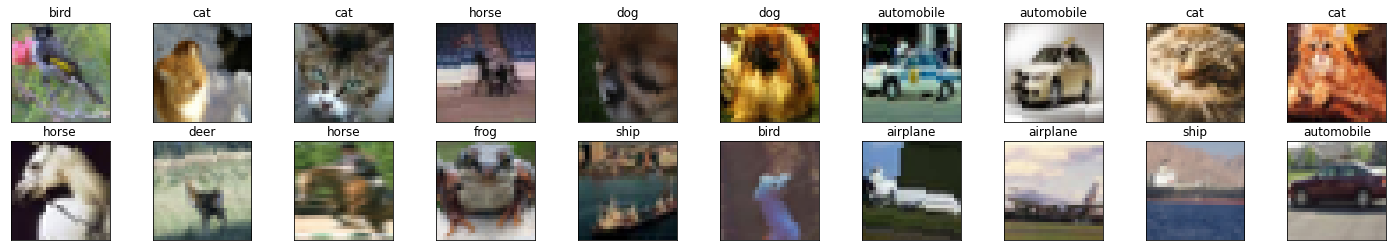

In [34]:
# Displaying one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

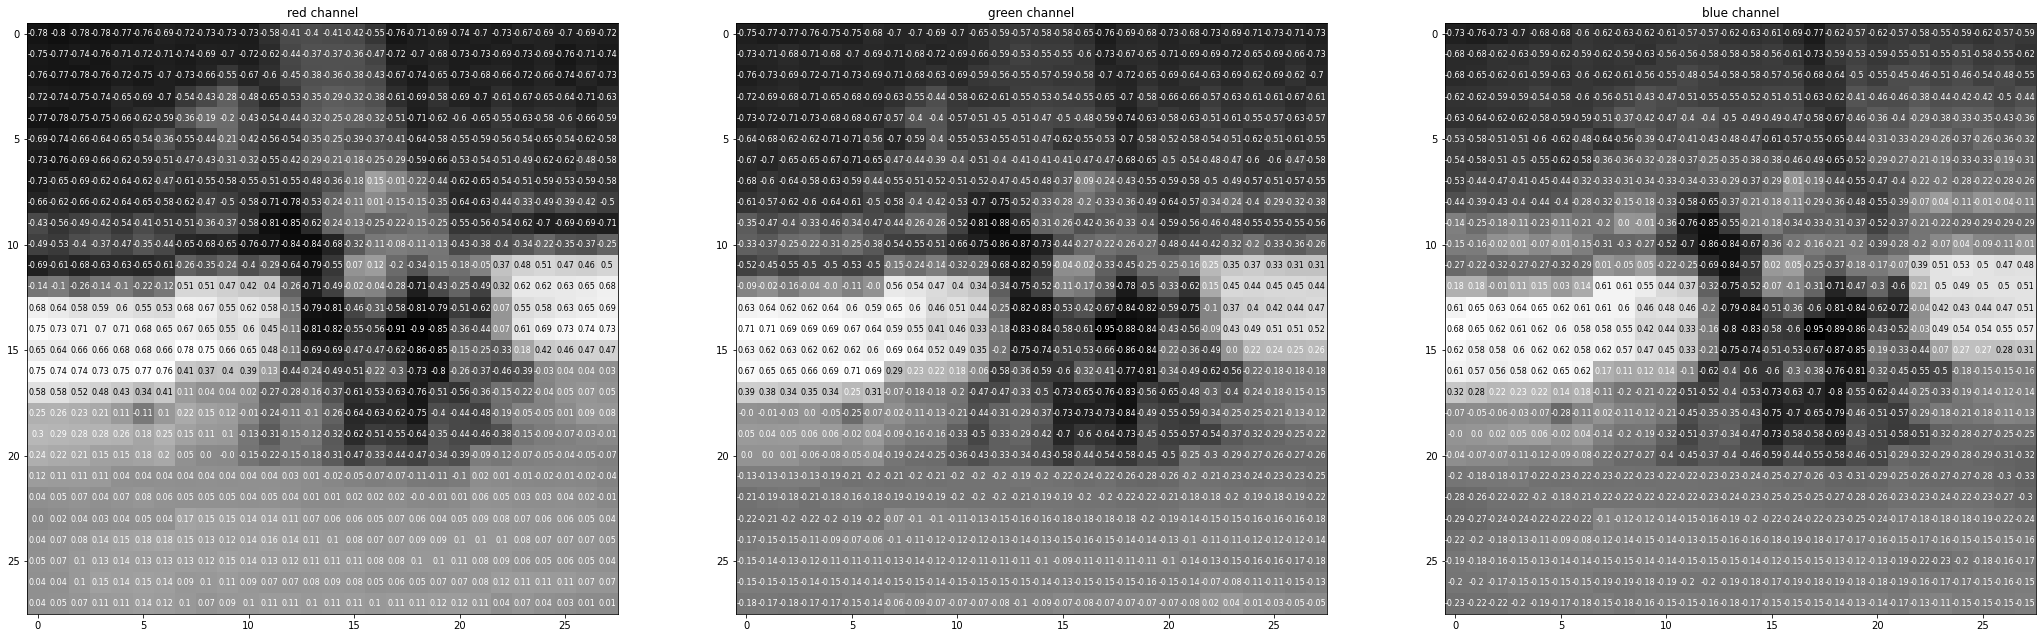

In [35]:
# Cool way of viewing images in detail...its a frog
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.
    
Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from Stanford's cs231n course):

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

In [36]:
#Defining CNN model 
# Output volume for a convolutional layer
# To compute the output size of a given convolutional layer we can perform the following calculation 
# We can compute the spatial size of the output volume as a function of the input volume size (W), 
# the kernel/filter size (F), the stride with which they are applied (S), 
# and the amount of zero padding used (P) on the border.
# The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding =1)
        self.conv2 = nn.Conv2d(16,32,3,padding =1)
        self.conv3 = nn.Conv2d(32,64,3,padding =1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*3*3,500)
        self.fc2 = nn.Linear(500,10)
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        # converting size for the batch of images into vector for 
        x = x.view(-1,64*3*3)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  #Don't apply activation function if criterion has to be CrossEntropyLoss in classification task
        return x
        
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda()

model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [37]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    # This is the implementation of "Early stopping"
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.769979 	Validation Loss: 1.499026
Validation loss decreased (inf --> 1.499026).  Saving model ...
Epoch: 2 	Training Loss: 1.474781 	Validation Loss: 1.395411
Validation loss decreased (1.499026 --> 1.395411).  Saving model ...
Epoch: 3 	Training Loss: 1.381889 	Validation Loss: 1.441922
Epoch: 4 	Training Loss: 1.327434 	Validation Loss: 1.294575
Validation loss decreased (1.395411 --> 1.294575).  Saving model ...
Epoch: 5 	Training Loss: 1.271705 	Validation Loss: 1.239593
Validation loss decreased (1.294575 --> 1.239593).  Saving model ...
Epoch: 6 	Training Loss: 1.235662 	Validation Loss: 1.239895
Epoch: 7 	Training Loss: 1.204555 	Validation Loss: 1.199501
Validation loss decreased (1.239593 --> 1.199501).  Saving model ...
Epoch: 8 	Training Loss: 1.172605 	Validation Loss: 1.181972
Validation loss decreased (1.199501 --> 1.181972).  Saving model ...
Epoch: 9 	Training Loss: 1.151336 	Validation Loss: 1.161528
Validation loss decreased (1.181972 --> 1.

In [38]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

In [39]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.056633

Test Accuracy of airplane: 63% (634/1000)
Test Accuracy of automobile: 77% (772/1000)
Test Accuracy of  bird: 40% (408/1000)
Test Accuracy of   cat: 42% (428/1000)
Test Accuracy of  deer: 54% (546/1000)
Test Accuracy of   dog: 63% (639/1000)
Test Accuracy of  frog: 69% (691/1000)
Test Accuracy of horse: 70% (709/1000)
Test Accuracy of  ship: 71% (713/1000)
Test Accuracy of truck: 72% (729/1000)

Test Accuracy (Overall): 62% (6269/10000)


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


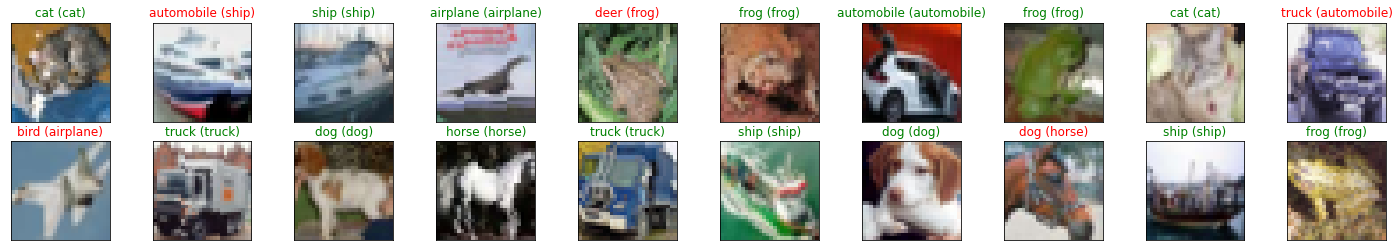

In [42]:
# Visualizing the performance
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))